# EM538: Homework 1: kNN Regressor

See: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html


EM 538: Practical Machine Learning for Engineering Analytics (Spring 2025)

- Instructor: Fred Livingston (fjliving@ncsu.edu)
- Student: Mike Keating


## California Housing Prices Dataset


### Task 1: Load Housing Dataset [ 16 pts ]


In [2]:
import pandas as pd

df_housing = pd.read_csv("housing.csv", usecols=["longitude", "latitude", "median_house_value"])

We can answer all of part one by using the info() method on our dataframe:


In [3]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   median_house_value  20640 non-null  float64
dtypes: float64(3)
memory usage: 483.9 KB


- 1a. How many features (m) are in the dataset [ 4 pts ]
  - There are 3 features
- 1b. Describe the features names [ 4 pts ]
  - The feature names are longitude, latitude, and median_house_value.
- 1c. How many samples (n) are in this dataset [ 4 pts ]
  - n = 20640
- 1d. Describe the classification outputs (datatypes, etc) y [ 4 pts ]
  - All datatypes are float64.


### Task 2: Visualize Housing Data [ 15 pts ]


- 2a. Using the California Data set, plot the median house value, w.r.t to the following features: longitude, latatitude [ 13 pts ]


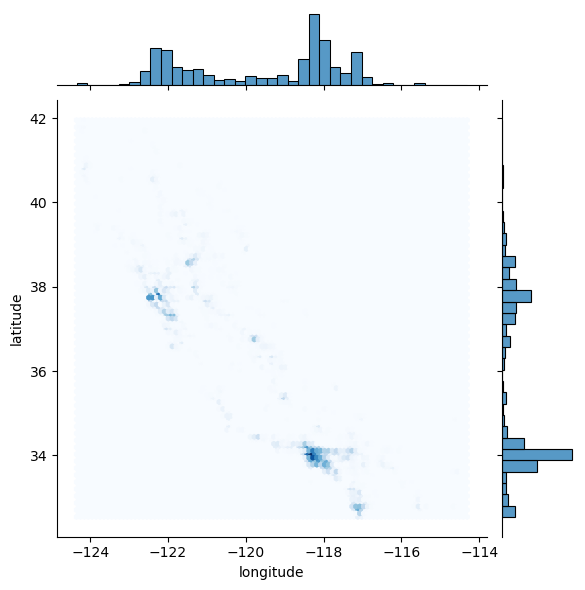

In [4]:
import seaborn as sns

g = sns.jointplot(x="longitude", y="latitude", data=df_housing, kind="hex", gridsize=100, cmap="Blues")


- 2b. Where are the most expensize house located [ 2 pts ]

From the above image (you can see the shape of California), the most expensive homes are located in the Bay Area, Los Angeles area, and San Diego (farthest south)


### Task 3: Prepare Training, Testing Datasets [ 14 pts ]

Using the Simple Holdout Method with a random seed of 123, Randoms sample 20% of the Data for Testing, and the remainder for Training


#### 3a. Implement the Simple Holdout Method Algorith in the bellow cell [ 8 pts ]


In [5]:
# Prepare Training, and Testing Datasets
from sklearn.model_selection import train_test_split

# Longitude and latitude are our features/predictors.
X = df_housing[["longitude", "latitude"]]
y = df_housing[["median_house_value"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123, shuffle=True)

#### 3b. Determine the size of the Training Set [ 3 pts ]


In [6]:
import numpy as np

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")


X_train.shape: (16512, 2)
y_train.shape: (16512, 1)


#### 3c. Determine the size of the Testing Set [ 3 pts ]


In [7]:
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")


X_test.shape: (4128, 2)
y_test.shape: (4128, 1)


### Task 4: - Fit k-Nearest Neighbor Model [ 45 pts ]


Next, we are going to use the `KNeighborsRegressor` class from scikit-learn and instantiate a new KNN object, which we call `knn_model`. Then, we "fit" this model the training dataset.

Training our model on all possible K values (odd) from 3 to 10:

Chose an odd value of K when you have 2 classes to avoid ties. i.e. If the new data point is right between the two classes it cannot decide which one to go with.
K must not be a multiple of the number of classes
If K is very small ( Overfit ), will not be accurate if you have many data points (n)
If K is very large ( Underfit ), K must not be equal to the number of data points n


#### 4a. Implement the KNeighborsRegressor for k = 3, 5, 7, and 11 [ 35 pts ]


In [26]:
# Train a KNeighbors Regression model
# Here I did it without a pipeline first
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import max_error
import pandas as pd

k_values = [3, 5, 7, 11]
models = []

for k_value in k_values:
    model_dict = {}
    knn_model = KNeighborsRegressor(n_neighbors=k_value)

    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)

    # Calculate the max error.
    model_dict["n_neighbors"] = k_value
    model_dict["coeff_det"] = knn_model.score(X_test, y_test)
    model_dict["max_error"] = max_error(y_test, y_pred)

    # Add model to list
    models.append(model_dict)

# S
results = pd.DataFrame(models).sort_values(by="max_error", ascending=True)
results.head()

,n_neighbors,coeff_det,max_error
3,11,0.796581,327637.363636
2,7,0.795447,329214.428571
0,3,0.778178,329933.333333
1,5,0.791966,337480.000000


#### 4b. Determine the optimal n_neighbors based on Max Error [ 5 pts ]

For knn models where n-neighbors is 3,5,7, and 11:
The model with n-neighbors = 11 peformed the best when condsidering max error.

Below I will repeat the process with a higher number of estimators and a pipeline.


In [9]:
# Using a pipeline and adding some extra n_neighbors optiions in params range
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

param_range = [1, 3, 5, 7, 9, 11, 13, 15, 17]

pipe_knn = make_pipeline(StandardScaler(), KNeighborsRegressor())

param_grid = [{"kneighborsregressor__n_neighbors": param_range}]

gs = GridSearchCV(estimator=pipe_knn, param_grid=param_grid, scoring="neg_max_error", cv=10, n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(f"The best knn model:{gs.best_params_}")


The best knn model:{'kneighborsregressor__n_neighbors': 11}


#### 4c. What is the maximum error of the prediction [ 5 pts ]


In [10]:
print(f"Maximum error of best performing model: {gs.best_score_:.2f}")

Maximum error of best performing model: -323044.20


### Task 5: Evaluate the Accuracy of the best performing model and determine is Max Error [ 10 pts ]


#### 5a. Using the Test Data set, determine the accuracy of the final model [ 5 pts ]


In [27]:
# We are going to use r^2 score (coefficient of determination) to evaluate the "accuracy" of our model in combination with mean squared error
# We are gonna create a new GridSearch object to find the best performing model based on these metrics
# NOTE: The model selected by this method may not be the same model as selected for max error.

gs2 = GridSearchCV(estimator=pipe_knn, param_grid=param_grid, scoring="r2", cv=10, n_jobs=-1)

gs2 = gs2.fit(X_train, y_train)

print(f"The best knn model:{gs2.best_params_}")
print(f"RMSE: {gs2.best_score_:.2f}")

The best knn model:{'kneighborsregressor__n_neighbors': 7}
RMSE: 0.78


It appears n=11 is the optimal number of neighbors when also considering the coefficient of determination and MSE as scores.

It has the same max error as we mentioned previously:


#### 5b. Show Price prediction using the test data set [ 5 pts ]


In [ ]:
gs2.predict(X_test)


array([[214914.28571429],
       [ 68414.28571429],
       [139814.28571429],
       ...,
       [ 77371.42857143],
       [249871.42857143],
       [326343.        ]])